<a href="https://colab.research.google.com/github/dhirajtiwari/practiceapps/blob/master/Fine_Tuning_HF_resume_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers datasets
!pip install --upgrade accelerate
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.0 MB/s eta 0:00:00
Found existing installation: transformers 4.37.2
Uninstalling transformers-4.37.2:
  Successfully uninstalled transformers-4.37.2
Found existing installation: accelerate 0.27.2
Uninstalling accelerate-0.27.2:
  Successfully uninstalled accelerate-0.27.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 27.3 MB/s eta 0:00:00
  Using cached accelerate-0.27.2-py3-none-any.whl (279 kB)


In [3]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
from datasets import load_dataset

df_org = load_dataset("Dh1raj/resume-labelled-encoded")
df_org["train"][300]

Generating train split:   0%|          | 0/1738 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/746 [00:00<?, ? examples/s]

{'text': 'dining services coordinator professional summary i have worked in fine dining in hotels for more than half of my career and i also have experience in the hospitalsetting i have been in the elderly care field for the last 20 years i have menu creativity and i can work a smallbudget or a large one i dont believe in waste therefore i will use leftovers to create wonderful soups sauces and salads expert in managing kitchen staff and preparing foods at reduced cost without compromising quality and taste skills team leadership budgeting and finance selfmotivated strong verbal communication staff development employee training and development finedining expertise ordering and invoicing cpr certification committed team player process implementation institutional and batch cooking beautiful presentation of food strong attention to safe food handling procedures effective planner food presentation talent servsafe certification outgoing and energetic training personnel work history dining

In [ ]:
df_org['validation']['label']

In [7]:
df_org.keys()

dict_keys(['train', 'validation'])

In [8]:
from datasets import load_dataset

# Load the dataset
df_org = load_dataset("Dh1raj/resume-labelled-encoded")

# Extract unique labels from the dataset
all_labels = set()
for split in df_org.keys():
    all_labels.update(df_org['train']["label"])

# Assign an ID to each unique label
label2id = {label: idx for idx, label in enumerate(all_labels)}
id2label = {idx: label for label, idx in label2id.items()}

# Print the mappings
print("Label to ID mapping:")
print(label2id)
print("\nID to Label mapping:")
print(id2label)


Label to ID mapping:
{'BUSINESS-DEVELOPMENT': 0, 'CONSTRUCTION': 1, 'AUTOMOBILE': 2, 'AGRICULTURE': 3, 'ARTS': 4, 'DESIGNER': 5, 'BANKING': 6, 'DIGITAL-MEDIA': 7, 'TEACHER': 8, 'ENGINEERING': 9, 'ACCOUNTANT': 10, 'FITNESS': 11, 'CONSULTANT': 12, 'CHEF': 13, 'FINANCE': 14, 'ADVOCATE': 15, 'BPO': 16, 'PUBLIC-RELATIONS': 17, 'AVIATION': 18, 'HEALTHCARE': 19, 'INFORMATION-TECHNOLOGY': 20, 'SALES': 21, 'APPAREL': 22, 'HR': 23}

ID to Label mapping:
{0: 'BUSINESS-DEVELOPMENT', 1: 'CONSTRUCTION', 2: 'AUTOMOBILE', 3: 'AGRICULTURE', 4: 'ARTS', 5: 'DESIGNER', 6: 'BANKING', 7: 'DIGITAL-MEDIA', 8: 'TEACHER', 9: 'ENGINEERING', 10: 'ACCOUNTANT', 11: 'FITNESS', 12: 'CONSULTANT', 13: 'CHEF', 14: 'FINANCE', 15: 'ADVOCATE', 16: 'BPO', 17: 'PUBLIC-RELATIONS', 18: 'AVIATION', 19: 'HEALTHCARE', 20: 'INFORMATION-TECHNOLOGY', 21: 'SALES', 22: 'APPAREL', 23: 'HR'}


In [9]:
df_org= df_org.remove_columns(['__index_level_0__'])
df_org

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1738
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 746
    })
})

In [10]:
import pandas as pd

# Convert the list of dictionaries to a DataFrame
train_df = pd.DataFrame(df_org["train"])

# Map the labels to their corresponding IDs and assign the mapped values to a new column 'labels'
train_df["labels"] = train_df["label"].map(lambda x: label2id[x.strip()])

# Print the DataFrame to verify the mapping
print(train_df.head())


                                                text                   label  \
0  passenger service agent career overview custom...                 APPAREL   
1  database programmeranalyst net developer summa...  INFORMATION-TECHNOLOGY   
2  business development specialist summary retire...    BUSINESS-DEVELOPMENT   
3  senior construction manager summary constructi...            CONSTRUCTION   
4  national marine fisheries service nmfs species...             AGRICULTURE   

   labels  
0      22  
1      20  
2       0  
3       1  
4       3  


<Axes: >

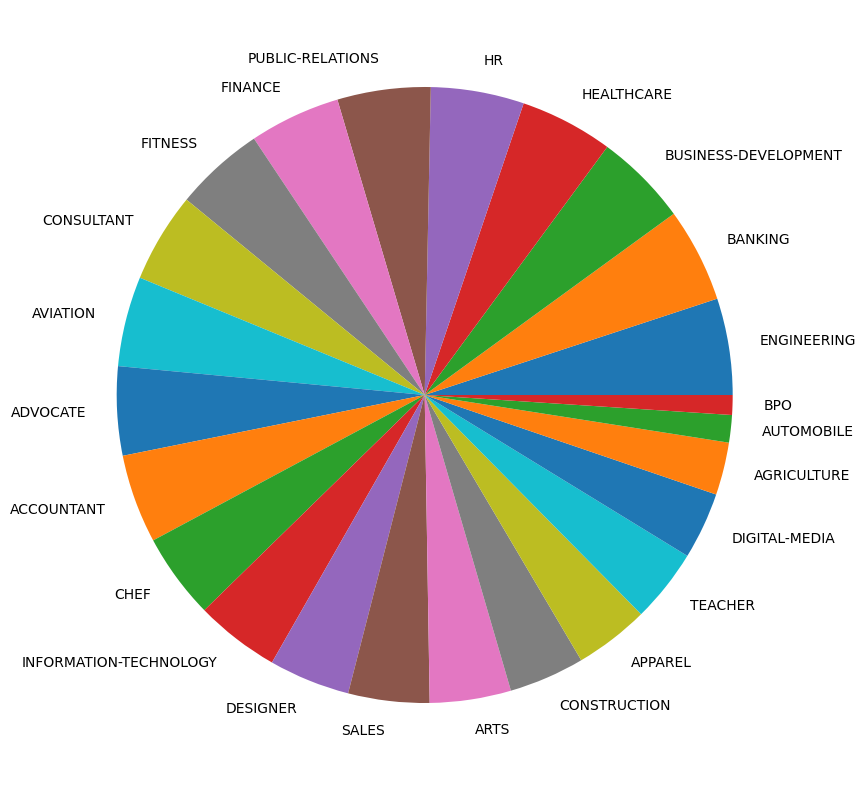

In [11]:
# Assuming df_org is your DatasetDict and you want to access the "train" split
# Replace "train" with the appropriate split if needed
labels = df_org["train"]["label"]

# Convert the list of labels to a Pandas Series
labels_series = pd.Series(labels)

# Plot the value counts of the "label" column as a pie chart
labels_series.value_counts().plot(kind='pie', figsize=(10, 10))



In [12]:
from transformers import BertTokenizerFast, BertForSequenceClassification

# Assuming you have defined label2id and id2label mappings
NUM_LABELS = len(label2id)

# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=128)

# Load the model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)

# Move the model to the appropriate device (e.g., GPU)
model.to(device)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=128)

In [14]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [15]:
df_org

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1738
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 746
    })
})

In [16]:
# Accessing the train, validation, and test splits from the DatasetDict
train_dataset = df_org["train"]
validation_dataset = df_org["validation"]

# Extracting the number of rows in each split
train_size = len(train_dataset)
validation_size = len(validation_dataset)


# Splitting the texts and labels accordingly
train_texts = [example["text"] for example in train_dataset]
train_labels = [example["label"] for example in train_dataset]

val_texts = [example["text"] for example in validation_dataset]
val_labels = [example["label"] for example in validation_dataset]



# Print the sizes of each split for verification
print("Train size:", train_size)
print("Validation size:", validation_size)



Train size: 1738
Validation size: 746


In [17]:
len(train_texts)

1738

In [18]:
len(train_texts), len(val_texts)

(1738, 746)

In [19]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)


In [20]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Map the label from string to numerical ID
        item['labels'] = torch.tensor(label2id[self.labels[idx]])  # Assuming label2id is a mapping dictionary
        return item

In [21]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)



In [22]:
from transformers import TrainingArguments, Trainer

In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):

    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [ ]:
#small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
#small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [25]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./dh1rajtextclass',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    # Number of steps used for a linear warmup
    warmup_steps=10,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [26]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [27]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,3.191700,3.144314,0.045576,0.005990,0.043515,0.042929
100,2.940400,2.529969,0.313673,0.198400,0.326865,0.263533
150,2.289300,1.829516,0.638070,0.522103,0.562795,0.570456
200,1.582400,1.251463,0.784182,0.678805,0.699407,0.707561
250,1.120000,1.036136,0.773458,0.668376,0.700246,0.693412
300,0.886400,0.898808,0.812332,0.733046,0.757457,0.741408
350,0.799100,0.825964,0.824397,0.745086,0.766041,0.752816
400,0.848900,0.734574,0.836461,0.773499,0.812788,0.768352
450,0.699000,0.745959,0.833780,0.759005,0.780415,0.763101
500,0.510300,0.710035,0.844504,0.771996,0.794520,0.775719


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

TrainOutput(global_step=654, training_loss=1.2548028657195764, metrics={'train_runtime': 844.1549, 'train_samples_per_second': 6.177, 'train_steps_per_second': 0.775, 'total_flos': 1372132025155584.0, 'train_loss': 1.2548028657195764, 'epoch': 3.0})

In [29]:
q = [trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader]]

pd.DataFrame(q, index=["train", "val"]).iloc[:, :5]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.479060,0.897583,0.839754,0.911787,0.840669
val,0.710035,0.844504,0.771996,0.794520,0.775719


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

In [33]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [31]:
df_org['train'][1]

{'text': 'database programmeranalyst net developer summary software engineer with 2 years in web developer specializing in front end development proficient in software development life cycle sdlc and scrum agile methodologies of development process to produce software solutions by team involved in designing planning developing and implementing microsoft net based solutions that meet quality and code standards developed web based applications using c aspnet javascript jquery css bootstrap css html xml and ajax strong experience in data retrieval and manipulation using adonet data objects such as dataset data reader data list data adaptor entity frame work good experience in writing class library using c linq to sql queries in database access layer to interface with sql database worked extensively with net server controls web user controls data grid web control form validation controls and created custom controls worked on creating and modifying table definitions stored procedures in sql

In [35]:
df_org['train'][256]

{'text': 'substitute teacher skills outlook excel word powerpoint quickbooks and onenote experience 092016 to current substitute teacher company name city state design learning environment to meet educational development objectives responsible for classroom schedule subject matter selection of materials and media development of learning activities and documentation of plans establish positive relationships with students parents fellow teachers and school administratorsstaff provide regular feedback to parents regarding work and behavior in class 092015 to 042016 maintenance technician company name city state managed 100 lots and ensured maintenance requests were fulfilled in a timely matter maintained electrical plumbing and landscaping informed management of potentially dangerous electrical equipment and faulty instrumentation recommended new equipment and maintenance procedures to the facility manager 042012 to 062014 sales associate company name city state enthusiastically conversed

In [34]:
# Test with a an example text -Test number 1
text = "'database programmeranalyst net developer summary software engineer with 2 years in web developer specializing in front end development proficient in software development life cycle sdlc and scrum agile methodologies of development process to produce software solutions by team involved in designing planning developing and implementing microsoft net based solutions that meet quality and code standards developed web based applications using c aspnet javascript jquery css bootstrap css html xml and ajax strong experience in data retrieval and manipulation using adonet data objects such as dataset data reader data list data adaptor entity frame work good experience in writing class library using c linq to sql queries in database access layer to interface with sql database worked extensively with net server controls web user controls data grid web control form validation controls and created custom controls worked on creating and modifying table definitions stored procedures in sql database modified and written web services using c to interact with the other applications so data can be served used red gate sql compare to deploy database from one server to another server dev testqaworked on net security features such as formbased authentication and rolebased authorization involved in bug fixes and production support worked closely with scrum master for backlog catalogs feature catalogs and prioritized the tasks participated in daily scrums and weekly meetings with the project sponsors to meet expectations and deadlines interact with qa to ensure the defects are properly cleared to attain the quality standards providing demos to the qa team at the end of the sprint to push for its final stage worked with crossfunctional teams to meet project highlights aspnet c javascript jquery vbnet c c java net technologies net framework 4045 aspnet aspnet mvc vbnet adonet entity framework ajax web service linq entity framework linq queries aspnet html css javascript jquery bootstrap css ide visual studio eclipse netbeans dreamweaver database sql mysql operating system windows version controls tortoise svn github others microsoft word excel access power point professional experience database programmeranalyst net developer jun 2014 to feb 2016 company name city state worked as graduate research assistant performing the duties of database programmeranalyst at application development network adn doit which supports university of missouri system faculty and students through agile and rapid creation of new applications projects atlas description this project is all about requesting scheduling the tutoring sessions there are three roles tied to application they are tutee tutor and scheduler a tutee requests for tutoring for the classes that heshe enrolled and gives availability apart from the class timing through availability grid and tutor submits availability a scheduler will go through those availabilities and schedule time and location for tutoring also there are some set of rules for dropping the tutoring sessions which are incorporated in this project the other piece of this project is automated emails through scheduled task which runs every day responsibilities created a availability calendar grid in grid each cell represents time 1 hour span and day of the week clicking on the cell toggles the availability automatically populated the course schedule which comes from different databaseworked with data warehouse team in order to get that data developed c console application for scheduled email task got rid of data tables and table adapters in the main project as they are tightly coupled created class libraries out of the main project to access the database which can be used by both console application for schedule task and web application integrated open source html text editor ckeditor into the website used jquery for filtering sorting and search the listview javascript for clientside validations used role based authorization for various pages the goal of the project to refractor the old application with new templates and replace the assemblies adding functionalities to upload pdf files responsilities created separate login page for administrator and students used active directory ad group to restrict other department students developed a web interface for administrators to upload the pdf files into database which can be viewed by students updated the entire application by using new visual studio 2013 template which make use of bootstrap css by changing the master pages modified the structure of database to login used redgate sql compare to copy the data from database from dev server to test sever replaced the old adn utilities assemblies with new doit utilities assemblies appinventory description the goal of the project to allow the admins managers scrum masters of the organization to keep track various applications which includes their developed ongoing and future projects for every application there are application parameters which includes app structure remedy group user departments etc and each application has different version for each version the parameters are prod qa test url dcl database platforms framework used to develop application uat dates etc scrum masters can estimate the length and cost to build the application project estimator based on number of developers sprint length weeks of uat etc which they can share with clients after starting the project they can keep track of current progress by budget sprint burndown charts responsibilities entity framework was used using database first approach linq was used in the dal data access layer to interact with the database consumed adonet entity frame work for entity data model entities relationship mapping and querying data console application to import the data from csv files to populate them into the system automatic logout when user is idle for a specified time by using session parameters and javascript used client side validations onbeforeunload and onunload events in javascript worked on agile environment participated in daily scrum meetings to discuss the status of development planning and estimating the points and uat goadmin description gomizzou is the university of missouri flagship mobile application designed to provide services to all possible users of the university the goal of this project is to allow gomizzou staff to edit the master tables involved with the gomizzou webservices these master tables are the starting point for all window services which feed the web services production url responsibilities developed application using ajax controls like modal popup aspnet server controls like listview formview worked on clientside and server side validations and created master pages filtering of the data of listview based on the role used ntier architecture created the business logic layer by using class libraries to interact with database modified the existing webservices like socialspirit news webservices events web and windows services created aspnet user controls to reduce the complexity of user interface design created dynamic queries stored procedures views and triggers in sql server for the database manipulation mizzou checkout the goal of the project is to develop a web application for checkout process similar to shopping cart for various departments who met the certain rules responsibilities used smpt server to send emails developed c class library to import the data from the csv file to system lim service for late fee assessment access to page based on the role role based authentication personalized email for outlook the goal of the project to give students to customize their outlook email education master of science computer engineering present university of missouri state gpa gpa 37 computer engineering gpa 37 bachelor of technology electrical and electronics engineering may 2013 jawaharlal nehru technological university india gpa gpa 365 electrical and electronics engineering gpa 365 skills aspnet vbnet active directory adonet dreamweaver web development agile ajax html ide java javascript jquery analyst application development approach budget c c catalogs charts css checkout process client clients data warehouse database dcl eclipse edit editor email estimating features frame functional logic meetings access c excel outlook power point windows window microsoft word network operating system page pdf programmer programming progress quality qa research scheduling scrum sdlc software development sorting sql sql server tables tutoring user interface design utilities validation visual studio website'"
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[0.0056, 0.0066, 0.0136, 0.0074, 0.0044, 0.0044, 0.1486, 0.0030, 0.0111,
          0.0060, 0.0082, 0.0085, 0.0578, 0.0043, 0.0086, 0.0104, 0.0129, 0.0033,
          0.0064, 0.0064, 0.6464, 0.0024, 0.0097, 0.0040]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(20, device='cuda:0'),
 'INFORMATION-TECHNOLOGY')

In [36]:
text = "'substitute teacher skills outlook excel word powerpoint quickbooks and onenote experience 092016 to current substitute teacher company name city state design learning environment to meet educational development objectives responsible for classroom schedule subject matter selection of materials and media development of learning activities and documentation of plans establish positive relationships with students parents fellow teachers and school administratorsstaff provide regular feedback to parents regarding work and behavior in class 092015 to 042016 maintenance technician company name city state managed 100 lots and ensured maintenance requests were fulfilled in a timely matter maintained electrical plumbing and landscaping informed management of potentially dangerous electrical equipment and faulty instrumentation recommended new equipment and maintenance procedures to the facility manager 042012 to 062014 sales associate company name city state enthusiastically conversed with customers about purchase needs and available products inquired about buying experience item preferences and future purchases tracked inventory and prepared for promotions by setting up displays adding signage and retagging merchandise recommended appropriate items and direct or lead customers to selections education and training bachelor of arts business administration management eastern oregon university city state business administration management skills buying experience documentation inventory selection of materials excel outlook powerpoint word plumbing quickbooks'"
predict(text)

(tensor([[0.0014, 0.0072, 0.0026, 0.0076, 0.0120, 0.0055, 0.0046, 0.0020, 0.8913,
          0.0047, 0.0025, 0.0057, 0.0121, 0.0018, 0.0017, 0.0059, 0.0031, 0.0060,
          0.0043, 0.0014, 0.0099, 0.0020, 0.0025, 0.0022]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor(8, device='cuda:0'),
 'TEACHER')

In [37]:
model_path = "Resume-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('Resume-text-classification-model/tokenizer_config.json',
 'Resume-text-classification-model/special_tokens_map.json',
 'Resume-text-classification-model/vocab.txt',
 'Resume-text-classification-model/added_tokens.json',
 'Resume-text-classification-model/tokenizer.json')

In [39]:
model_path = "Resume-text-classification-model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("text-classification", model=model, tokenizer=tokenizer)

In [43]:
from transformers import BertForSequenceClassification, BertTokenizerFast, pipeline

# Load the model and tokenizer
model_path = "Resume-text-classification-model"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

# Function to preprocess text
def preprocess_text(text, max_length=512):
    # Tokenize the text
    inputs = tokenizer(text, max_length=max_length, truncation=True, padding="max_length", return_tensors="pt")
    return inputs

# Example text
text = "hr generalist summary hr generalist with 8 yrs of professional experience in employee recruitment orientation engagement assimilation and termination procedures..."

# Preprocess the text
inputs = preprocess_text(text)

# Perform text classification
output = model(**inputs)


In [40]:
df_org['train'][26]

{'text': 'hr generalist summary hr generalist with 8 yrs of professional experience in employee recruitment orientation engagement assimilation and termination procedures highlights employee recruitment talent acquisition new employee orientations employee engagement and assimilation vendor management termination procedures ms office proficient experience hr generalist november 2006 to may 2015 company name city state onboarding welcoming the new employees onboard by ensuring they have a pleasant experience verifying and collecting all the mandatory educational employment documents performing a reference check on the day of on boarding incase any document is not available hr engagement and assimilation handling employees queries with respect to joining formalities taking induction for the new joinees and briefing them about ibm and the concerned bus to which they will be a part of briefing the new joiners on various policies like payroll payables medical insurance reimbursement superan

In [45]:
nlp("hr generalist summary hr generalist with 8 yrs of professional experience in employee recruitment orientation engagement assimilation and termination procedures.")



[{'label': 'HR', 'score': 0.937533974647522}]

In [46]:
df_org['train'][426]

{'text': 'senior student finance specialist summary a dedicated and focused business professional with 12 years of extensive experience in analyzing and researching data to find solutions to issues an expert in investigation and critical thinking a very well detail oriented individual who is adaptive to change and building relationships with teams and managers i am currently seeking for a career where my skills and abilities can be useful to the company as well as to challenge my growth experience senior student finance specialist january 2010 to current company name city state summary i am a dedicated and focused business professional with 12 years of extensive experience in analyzing and researching data to find solutions to issues i am an expert in investigation and critical thinking a very well detail oriented individual who is adaptive to change and building relationships with teams and managers i am currently seeking for a career where my skills and abilities can be useful to the

In [51]:

nlp("senior student finance specialist summary a dedicated and focused business professional with 12 years of extensive experience in analyzing and researching data to find challenge my growth evaluates students financial aids compliance with schools regulations and control assessments include isir and ccode evaluation loans and grants eligibility grades and attendance reviews and qa on other miscellaneous documents such as proof of hs graduation responsible for performing daily title iv and tuition refund calculations maintains the students general ledger by assuring all the academic years are balanced main adviser of students credit balances assisting other teams and departments processes national student loan database nslds student status confirmation reports sscr and submit accurate reports on time thus keeping them in compliance emphasis on time management to meet month end and quarter end deadlines supports interdepartmental teams regarding any issues with out of school students ample use of microsoft excel vlookups pivottables formulas creating simple macros etc promoted from student accounts processor in which responsibilities included all postings to the ledger financial aid funding credit card refunds and ach returns and reapplications of payments in campusvue reviewed agency sponsors and sent out wires to higher one takes on projects when needed as well as works on weekends during monthquarter end invoicing associate january 2008 to january 2010 company name city state researched and assigned the correct identifiers for each customers based on their regions performed updates and movements of customers based on their regions utilized independent decision making skills on each assignment with the use of diverse software and computer applications ie tcam execustar sam saart web ciam and q messenger resolved issues concerning accounts that are in the wrong channels for the sales operation lead retained database by determining customers legal corporate structures and hierarchies created procedures for tcam usage for new hires and for future references adjustments associate january 2007 to january 2008 company name city state investigated and adjusted item processing centers bank teller errors based on their regions processed requests on items posting twice missing items source of receipt listed not enclosed photo and original items encoding errors and missing cash letter items validated all of bank of americas adjustments to banco popular by debiting or crediting appropriate accounts ")


[{'label': 'FINANCE', 'score': 0.9150175452232361}]

In [55]:
pt_model.push_to_hub("Resume-text-classification-model")

NameError: name 'pt_model' is not defined

In [53]:
from transformers import PushToHubCallback

push_to_hub_callback = PushToHubCallback(
    output_dir=".//content/Resume-text-classification-model", tokenizer=tokenizer, hub_model_id="dh1raj/bert-base-uncase-resume-class"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/dh1raj/bert-base-uncase-resume-class into local empty directory.


In [54]:
tokenizer.push_to_hub("bert-base-uncase-resume-class")

README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Dh1raj/bert-base-uncase-resume-class/commit/2f4ed3f704b3b436187a91795394e76434e1d4b8', commit_message='Upload tokenizer', commit_description='', oid='2f4ed3f704b3b436187a91795394e76434e1d4b8', pr_url=None, pr_revision=None, pr_num=None)